In [138]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


In [139]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [140]:
import pickle

def unpickle(file):
    """Load a batch file from CIFAR-10."""
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10(data_dir):
    """Load the CIFAR-10 dataset."""
    # Load training data
    train_data = []
    train_labels = []
    for i in range(1, 6):  # There are 5 training batches
        batch_file = f'{data_dir}/data_batch_{i}'
        batch_dict = unpickle(batch_file)
        train_data.append(batch_dict[b'data'])
        train_labels.extend(batch_dict[b'labels'])
    
    # Combine all training batches
    train_data = np.vstack(train_data)  # Shape: (50000, 3072)
    train_labels = np.array(train_labels)  # Shape: (50000,)

    # Load test data
    test_dict = unpickle(f'{data_dir}/test_batch')
    test_data = test_dict[b'data']  # Shape: (10000, 3072)
    test_labels = np.array(test_dict[b'labels'])  # Shape: (10000,)

    return train_data, train_labels, test_data, test_labels

# Path to the CIFAR-10 dataset directory
data_dir = '/kaggle/input/cifar10-python/cifar-10-batches-py'

# Load the dataset
train_data, train_labels, test_data, test_labels = load_cifar10(data_dir)

In [141]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(50000, 3072)
(50000,)
(10000, 3072)
(10000,)


In [142]:
train_data = train_data.reshape(-1,3,32,32).transpose(0,2,3,1)
test_data = test_data.reshape(-1,3,32,32).transpose(0,2,3,1)

print(train_data.shape)
print(test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


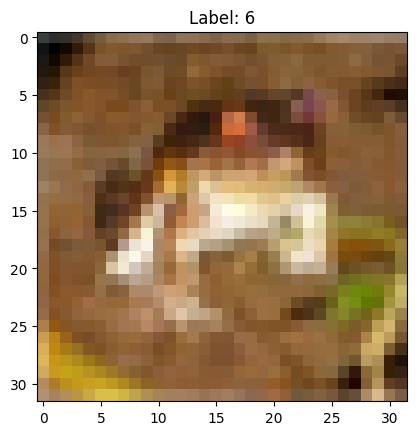

In [143]:
import matplotlib.pyplot as plt

# Display the first training image
plt.imshow(train_data[0])
plt.title(f"Label: {train_labels[0]}")
plt.show()

In [144]:
# Normalize the data
train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0

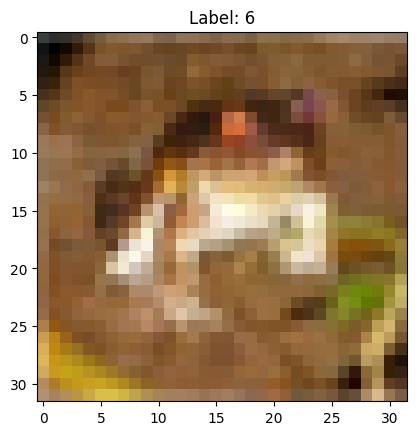

In [145]:
plt.imshow(train_data[0])
plt.title(f"Label: {train_labels[0]}")
plt.show()


In [146]:
# Convert numpy arrays to PyTorch tensors
train_data_tensor = torch.tensor(train_data).squeeze(1).float()
train_labels_tensor = torch.tensor(train_labels).long()

test_data_tensor = torch.tensor(test_data).squeeze(1).float()
test_labels_tensor = torch.tensor(test_labels).long()


In [147]:
train_dataset=TensorDataset(train_data_tensor,train_labels_tensor)
test_dataset=TensorDataset(test_data_tensor,test_labels_tensor)

#dataleader

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

In [148]:
for images,labels in train_loader:
    print("batch of images shape",images.shape)
    print("batch of labels:", labels)
    break

batch of images shape torch.Size([32, 32, 32, 3])
batch of labels: tensor([2, 9, 3, 0, 8, 9, 6, 3, 9, 4, 6, 7, 1, 3, 5, 6, 3, 1, 8, 6, 1, 9, 1, 8,
        0, 2, 7, 5, 3, 6, 1, 6])


In [149]:
train_data_tensor = train_data_tensor/255.0
test_data_tensor = test_data_tensor/255.0

In [153]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*8*8,512)
        self.fc2= nn.Linear(512,10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(-1,64*8*8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN()

In [154]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.permute(0, 3, 1, 2)  # Reorder input dimensions
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 100, Loss: 2.035
Epoch 1, Batch 200, Loss: 1.710
Epoch 1, Batch 300, Loss: 1.599
Epoch 1, Batch 400, Loss: 1.534
Epoch 1, Batch 500, Loss: 1.468
Epoch 1, Batch 600, Loss: 1.408
Epoch 1, Batch 700, Loss: 1.357
Epoch 1, Batch 800, Loss: 1.321
Epoch 1, Batch 900, Loss: 1.295
Epoch 1, Batch 1000, Loss: 1.235
Epoch 1, Batch 1100, Loss: 1.272
Epoch 1, Batch 1200, Loss: 1.222
Epoch 1, Batch 1300, Loss: 1.220
Epoch 1, Batch 1400, Loss: 1.182
Epoch 1, Batch 1500, Loss: 1.147
Epoch 2, Batch 100, Loss: 1.049
Epoch 2, Batch 200, Loss: 1.017
Epoch 2, Batch 300, Loss: 1.048
Epoch 2, Batch 400, Loss: 1.029
Epoch 2, Batch 500, Loss: 1.015
Epoch 2, Batch 600, Loss: 1.009
Epoch 2, Batch 700, Loss: 0.997
Epoch 2, Batch 800, Loss: 1.007
Epoch 2, Batch 900, Loss: 0.988
Epoch 2, Batch 1000, Loss: 1.017
Epoch 2, Batch 1100, Loss: 0.986
Epoch 2, Batch 1200, Loss: 0.911
Epoch 2, Batch 1300, Loss: 0.993
Epoch 2, Batch 1400, Loss: 0.958
Epoch 2, Batch 1500, Loss: 0.923
Epoch 3, Batch 100, Loss: 0.

In [160]:
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        images = images.permute(0, 3, 1, 2)  # Use images here, not inputs
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 69.42%


In [163]:
import torch
from sklearn.svm import SVC

# Convert train_data to PyTorch tensor if it's a numpy array
train_data_tensor = torch.tensor(train_data).float()  # Convert to float tensor

# Ensure the correct shape: [batch_size, channels, height, width]
train_data_tensor = train_data_tensor.permute(0, 3, 1, 2)  # If the data is in HWC format, permute to CHW

# Extract features using the CNN
class FeatureExtractor(nn.Module):
    def __init__(self, cnn):
        super(FeatureExtractor, self).__init__()
        self.cnn = cnn
        self.cnn.fc2 = nn.Identity()  # Remove the last layer

    def forward(self, x):
        return self.cnn(x)

# Create the feature extractor
feature_extractor = FeatureExtractor(model)
feature_extractor.eval()

# Extract features for training data (without gradients)
with torch.no_grad():
    train_features = feature_extractor(train_data_tensor)
    train_features = train_features.view(train_features.size(0), -1)  # Flatten the features

# Convert features to numpy for SVM
train_features = train_features.numpy()

# Train an SVM on the extracted features
svm = SVC()
svm.fit(train_features, train_labels)


SVC()

In [164]:

from sklearn.metrics import accuracy_score

test_data_tensor = torch.tensor(test_data).float()  # Convert to float tensor
print(f"test_data_tensor shape after conversion: {test_data_tensor.shape}")

test_data_tensor = test_data_tensor.permute(0, 3, 1, 2) 
print(f"test_data_tensor shape after permute: {test_data_tensor.shape}")

with torch.no_grad():
    test_features = feature_extractor(test_data_tensor)
    print(f"test_features shape after passing through CNN: {test_features.shape}")
    
    # Flatten the features
    test_features = test_features.view(test_features.size(0), -1)
    print(f"test_features shape after flattening: {test_features.shape}")

test_features = test_features.numpy()

svm_predictions = svm.predict(test_features)

# Calculate the accuracy on the test set
test_accuracy = accuracy_score(test_labels, svm_predictions)
print(f"SVM Test Accuracy: {test_accuracy * 100:.2f}%")

# Optionally, print some of the predictions and the corresponding true labels
print(f"First 5 true labels: {test_labels[:5]}")
print(f"First 5 predictions: {svm_predictions[:5]}")

# Print classification report if needed
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(test_labels, svm_predictions))


test_data_tensor shape after conversion: torch.Size([10000, 32, 32, 3])
test_data_tensor shape after permute: torch.Size([10000, 3, 32, 32])
test_features shape after passing through CNN: torch.Size([10000, 512])
test_features shape after flattening: torch.Size([10000, 512])
SVM Test Accuracy: 72.43%
First 5 true labels: [3 8 8 0 6]
First 5 predictions: [3 8 8 0 3]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      1000
           1       0.84      0.82      0.83      1000
           2       0.64      0.61      0.63      1000
           3       0.53      0.54      0.53      1000
           4       0.69      0.66      0.68      1000
           5       0.61      0.61      0.61      1000
           6       0.77      0.78      0.78      1000
           7       0.76      0.79      0.77      1000
           8       0.84      0.83      0.84      1000
           9       0.81      0.80      0.80      1000

    accuracy 